# Projet IA - Baptiste, François, Gabriel, Matteo

Le but du projet est de prédire le cours du blé dans le temps en fonction de variables explicatives minutieusement choisies.

## Importation des librairies

In [15]:
#Importation des librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from datetime import datetime, timedelta

# 1 - Préparation de la data


---
> Notre target: The S&P GSCI Wheat Index, a sub-index of the S&P GSCI, provides investors with a reliable and publicly available benchmark for investment performance in the **wheat commodity market**. (Source : S&P Global Website)



# 2 - Data preprocessing

## Importation de la dataset

In [16]:
df = pd.read_excel('Wheatdata.xlsx')

In [17]:
X = df.iloc[:, 1:6].values
y = df.iloc[:, -1].values
print(X)
print(y)
yforpredict=df.iloc[:, -1].values
df.info()

[[1.36200000e+03 8.58178177e+01 7.26100000e-01            nan
  1.92600000e+01]
 [1.31600000e+03 1.20928154e+02 7.25000000e-01            nan
  1.96100000e+01]
 [1.27300000e+03 9.47489090e+01 7.26400000e-01            nan
  1.97900000e+01]
 ...
 [1.58700000e+03            nan 9.30800000e-01 9.04900000e+01
  3.00800000e+01]
 [1.69000000e+03            nan 9.32100000e-01 9.02100000e+01
  3.12700000e+01]
 [1.72900000e+03            nan 9.39300000e-01 9.01300000e+01
  3.21900000e+01]]
[473.11 464.97 454.11 ... 387.11 384.22 387.28]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528 entries, 0 to 2527
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2528 non-null   datetime64[ns]
 1   balticdryindex  2446 non-null   float64       
 2   GPRindex        2524 non-null   float64       
 3   USDEUR          2528 non-null   float64       
 4   BRENT           2453 non-null   float64    

## Gestion des données manquantes

On va s'intéresser aux nombres de données manquantes sur nos variables explicatives:
- Pour plus de 1% de données manquantes, nous allons venir intégrer une moyenne de nos données pour les lignes où les données sont manquantes.

In [18]:
missing_values = df['balticdryindex'].isna().sum()
print(missing_values,"lignes manquantes.")
total_rows = df.shape[0]
print(total_rows,"lignes au total.")
percentage_missing = (missing_values / total_rows) * 100
print(percentage_missing,"% de données manquantes.")

82 lignes manquantes.
2528 lignes au total.
3.2436708860759493 % de données manquantes.


In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X[:, 0:5])
X[:, 0:5] = imputer.transform(X[:, 0:5])
print(X)

[[1.36200000e+03 8.58178177e+01 7.26100000e-01 6.75787648e+01
  1.92600000e+01]
 [1.31600000e+03 1.20928154e+02 7.25000000e-01 6.75787648e+01
  1.96100000e+01]
 [1.27300000e+03 9.47489090e+01 7.26400000e-01 6.75787648e+01
  1.97900000e+01]
 ...
 [1.58700000e+03 1.16282166e+02 9.30800000e-01 9.04900000e+01
  3.00800000e+01]
 [1.69000000e+03 1.16282166e+02 9.32100000e-01 9.02100000e+01
  3.12700000e+01]
 [1.72900000e+03 1.16282166e+02 9.39300000e-01 9.01300000e+01
  3.21900000e+01]]


On s'intéresse maintenant à observer les corrélations plausibles entre les variables de notre data à l'aide du matrice de variance-covariance ainsi qu'une représentation graphique mise à l'échelle de nos données.

In [20]:
# Calcul de la matrice de corrélation
correlation_matrix = df[['SPGSCI','balticdryindex', 'GPRindex','USDEUR','BRENT','OVXcrudeoil']].corr()

# Création d'une heatmap
heatmap = px.imshow(correlation_matrix,
                    labels=dict(color="Correlation"),
                    x=['SPGSCI','balticdryindex', 'GPRindex','USDEUR','BRENT','OVXcrudeoil'],
                    y=['SPGSCI','balticdryindex', 'GPRindex','USDEUR','BRENT','OVXcrudeoil'])
heatmap.show()

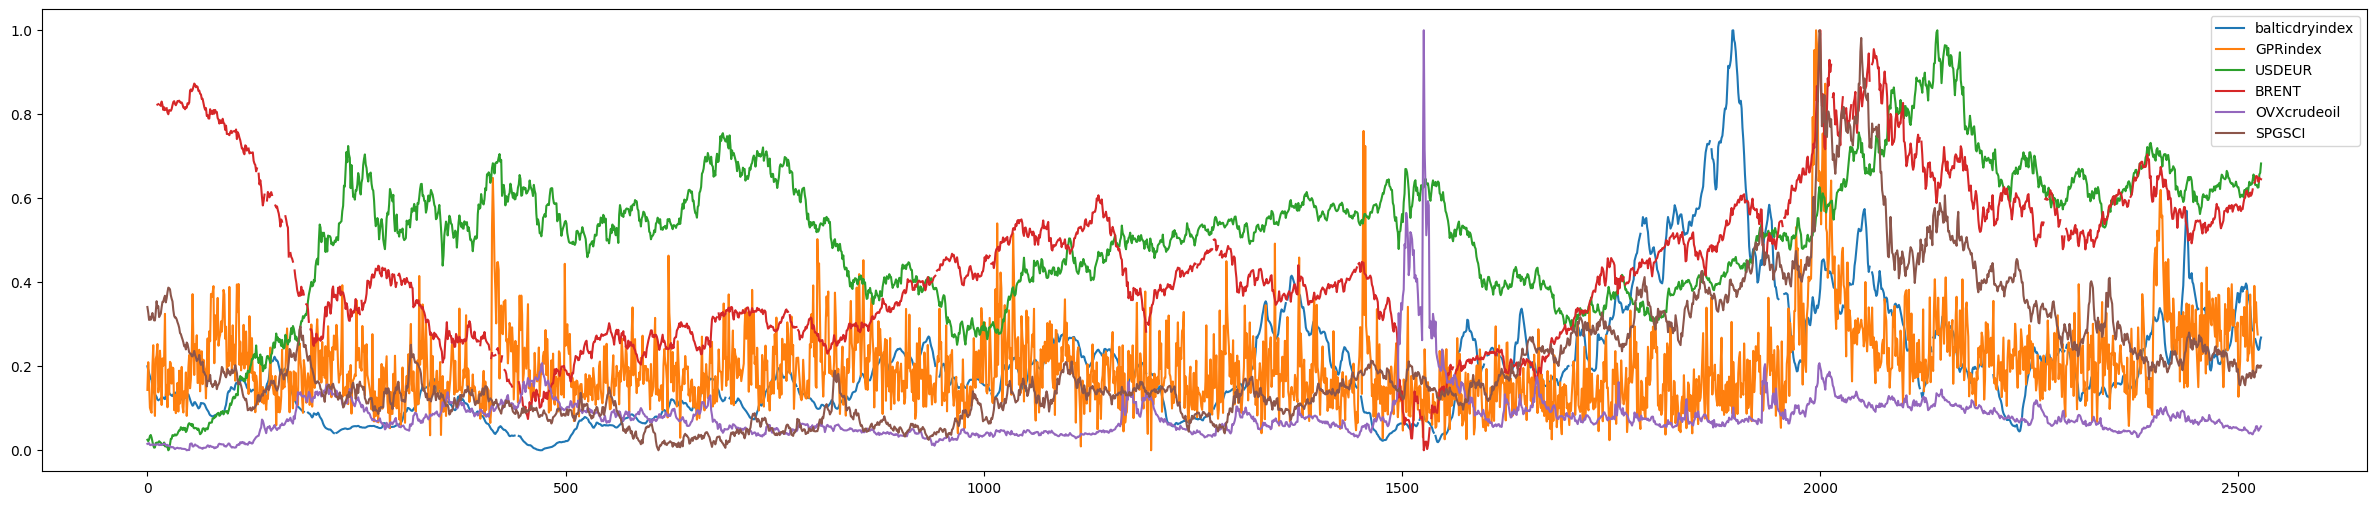

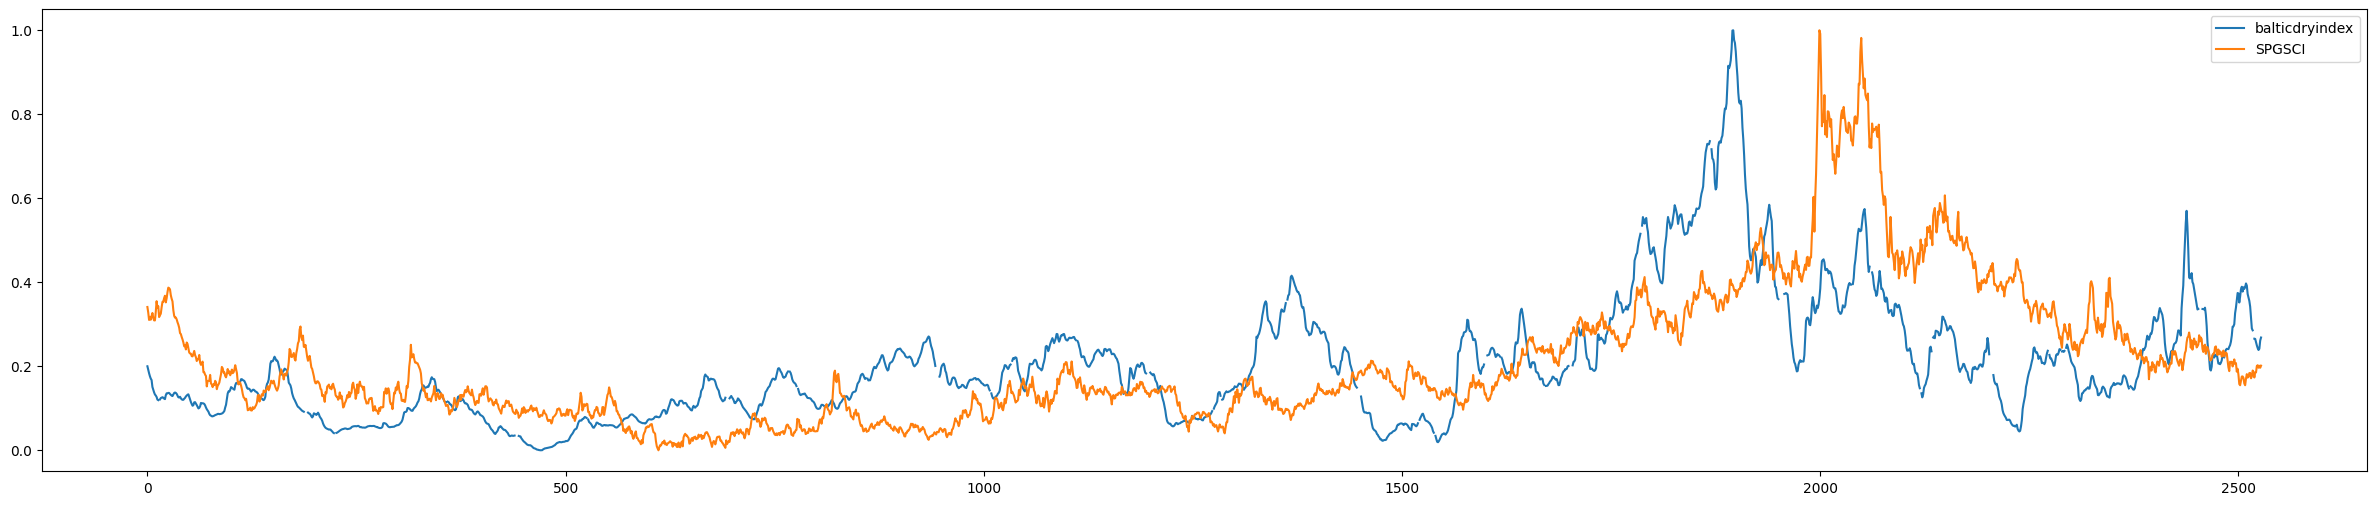

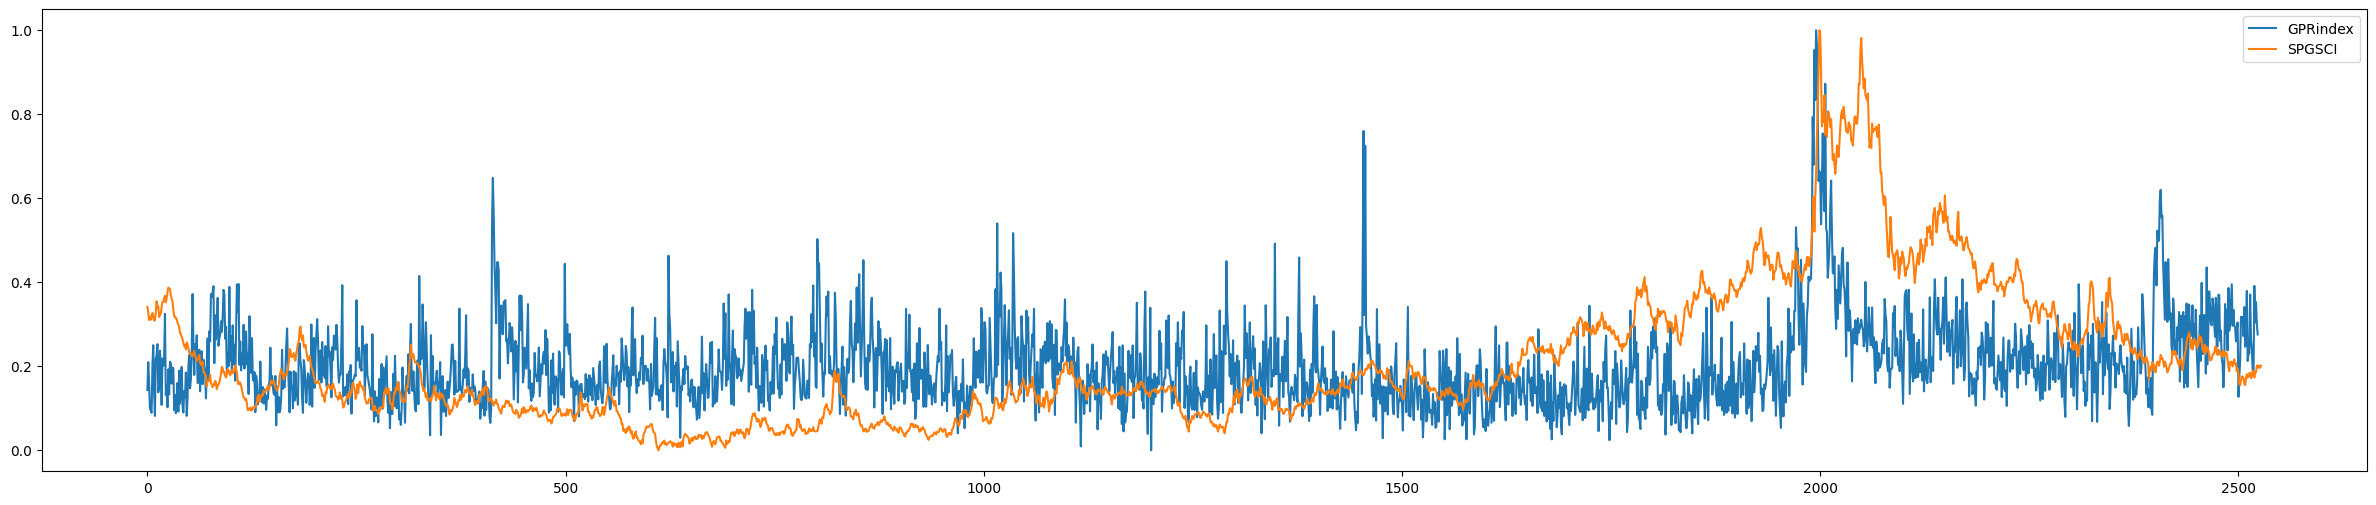

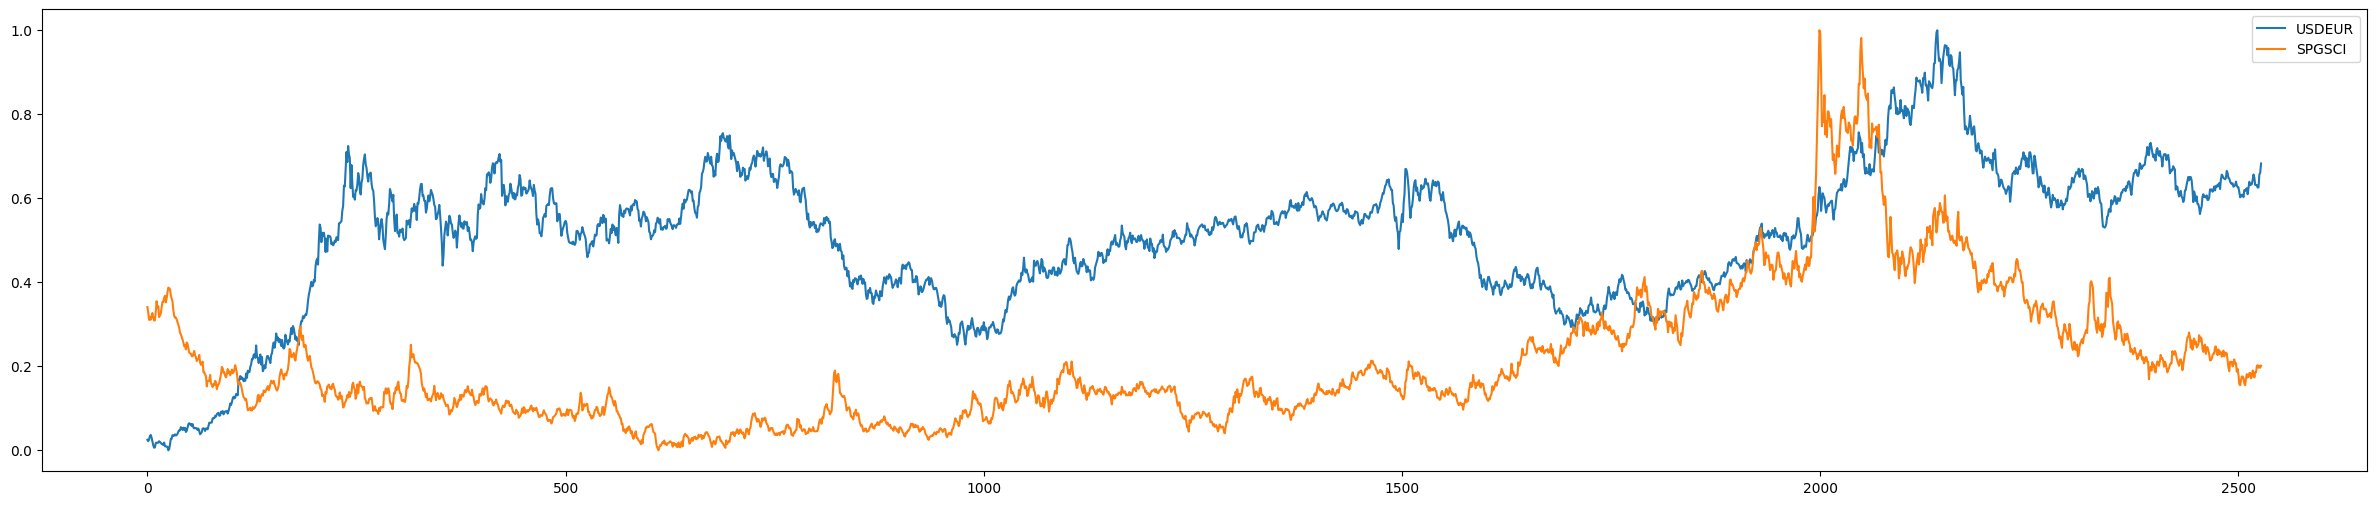

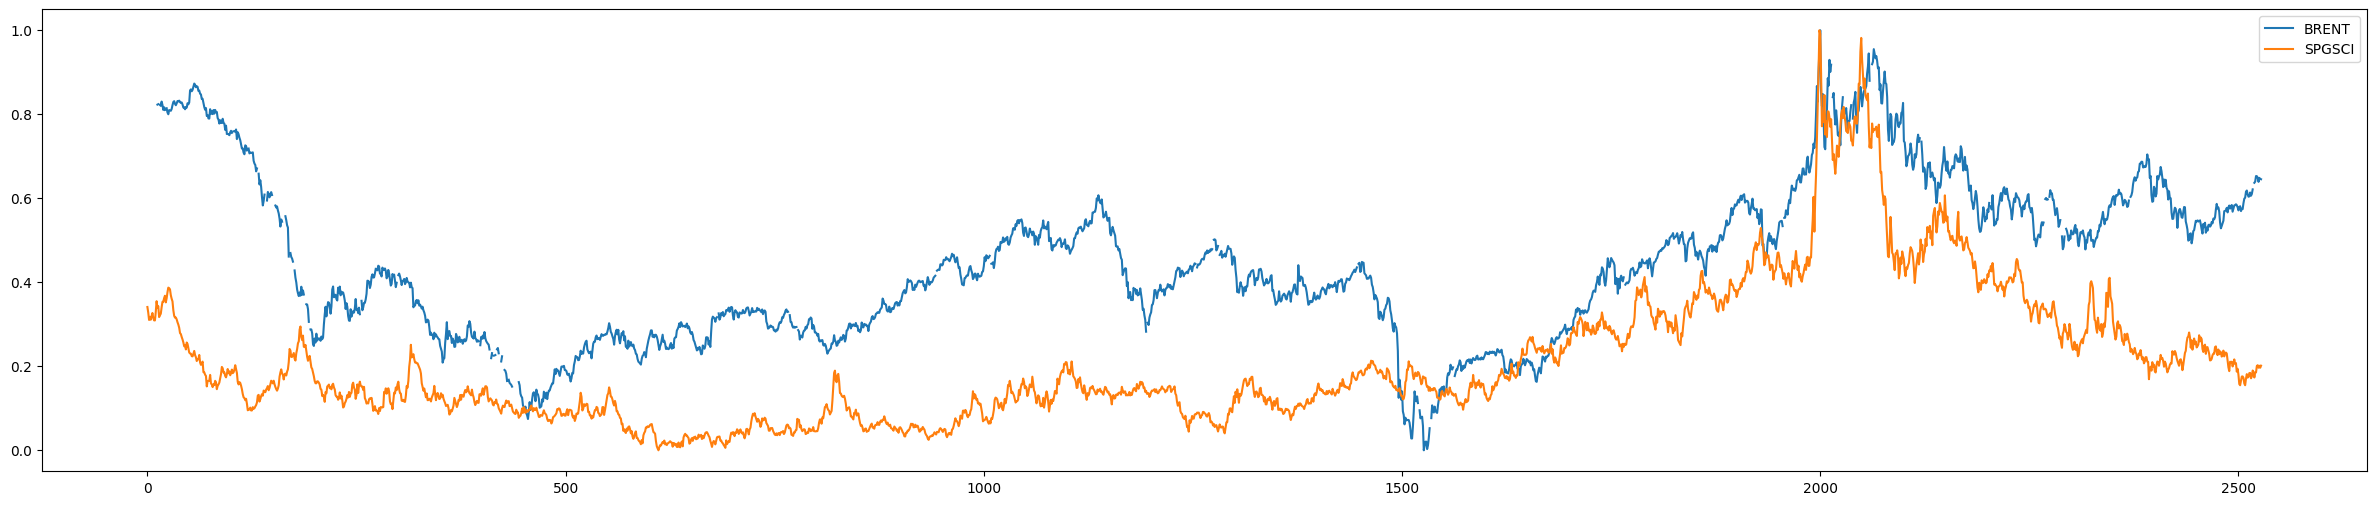

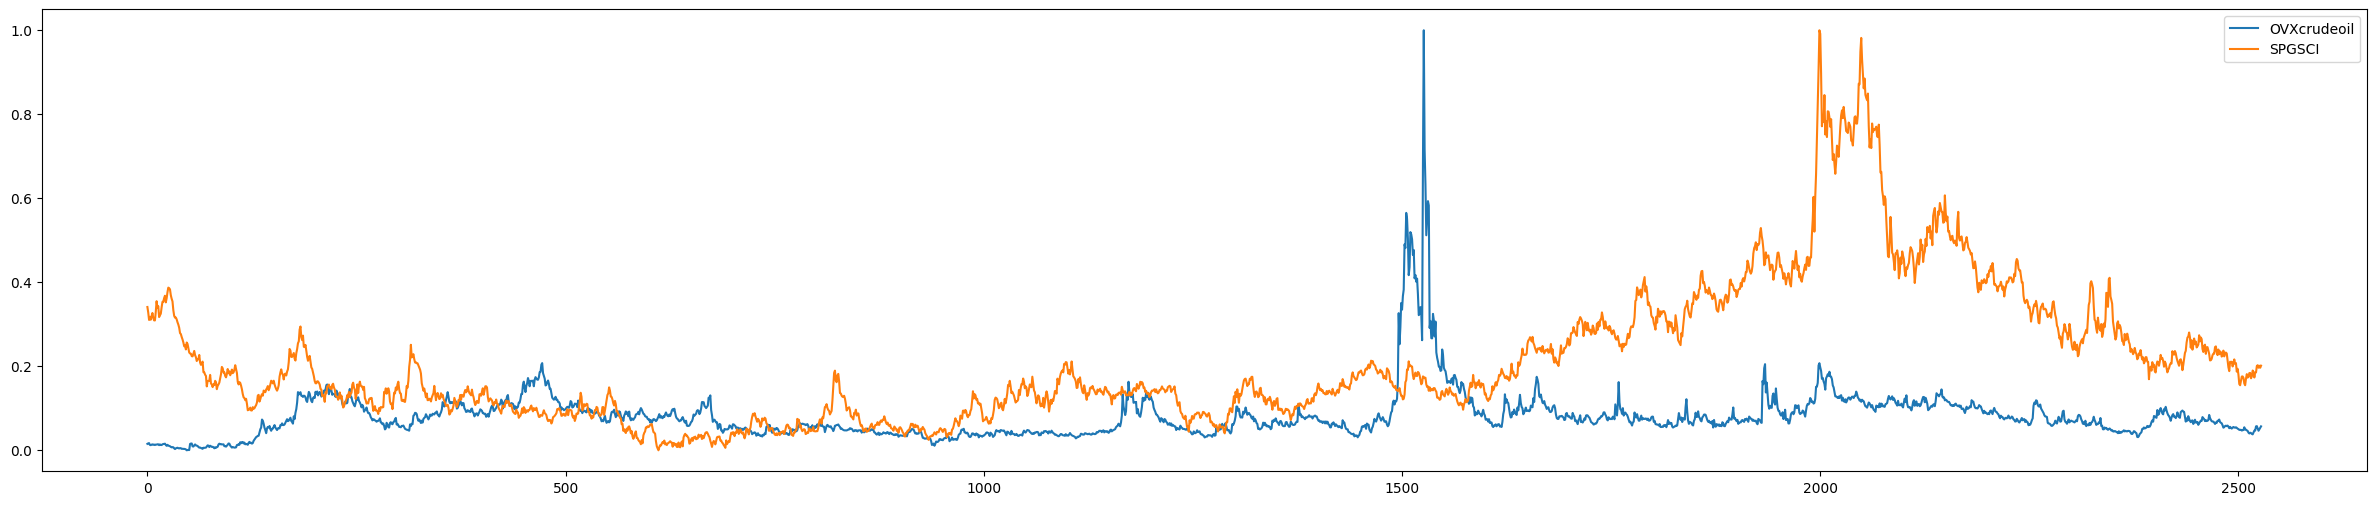

In [21]:
#Visualisation graphique de nos variables explicatives en comparaison avec notre target
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.iloc[:, 1:])
df_scaled = pd.DataFrame(data_scaled, columns=df.columns[1:])
df_scaled.plot(figsize=(30, 6))
plt.show()
scaler = MinMaxScaler()
for i in range(1,6):
  data_scaled = scaler.fit_transform(df.iloc[:, [i, -1]])
  df_scaled = pd.DataFrame(data_scaled, columns=[df.columns[i], df.columns[-1]])
  df_scaled.plot(figsize=(30, 6))



# 3 - Split de la dataset entre Training set et Test set

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

# 4 - Feature scaling

On normalise notre data afin de faire une mise à l'échelle qui sera plus appréciable pour utiliser de manière efficiente nos algorithmes de Machine Learning.

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)

[[-0.06017028 -0.70134171 -1.28449524 -0.76669482 -0.1401022 ]
 [-0.14250334 -0.92811022 -0.19226681 -0.44297308  0.34800878]
 [-0.55808923 -0.57929507 -1.88982666  0.94397224 -0.46751371]
 ...
 [-0.18301643  0.32788424  1.12179115 -0.58055482 -0.71074931]
 [-0.51496239 -1.20073581 -0.47049367 -0.94979992 -0.57246031]
 [-0.02749844 -0.35153611 -0.72052187 -1.24974835  0.22611769]]
[[-1.37619227  0.61627158  0.43938337 -1.74595307  1.38380981]
 [ 2.49607501 -1.49028146 -0.74872054  0.34660447 -0.04991372]
 [ 1.56427394 -0.96566427 -1.2280979   0.15540632 -0.34343623]
 ...
 [-0.33200005 -0.49855456 -1.4612069   0.10533062 -0.67412732]
 [ 1.36693598  2.17047859  0.33410834  2.225708    1.24333442]
 [-0.37774064 -0.17212072  2.24597808  1.68600316  0.40266847]]


# 5 - Régression linéaire multiple

*   Nous permet d'avoir une première approche de modélisation




L'objectif est d'appliquer un premier modèle à nos données (modèle vu en TD)

In [24]:
model = OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.043
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              13.68
Date:                Tue, 11 Mar 2025   Prob (F-statistic):                    4.35e-13
Time:                        09:25:25   Log-Likelihood:                         -11217.
No. Observations:                1516   AIC:                                  2.244e+04
Df Residuals:                    1511   BIC:                                  2.247e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

On calcule nos métriques de performance afin de mieux appréhender l'efficacité du modèle.

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_train = linear_reg.predict(X_train)
y_pred_test = linear_reg.predict(X_test)

print("Train MSE: ", mean_squared_error(y_train, y_pred_train), "\tTest MSE: ", mean_squared_error(y_test, y_pred_test))
print("Train R2: ", r2_score(y_train, y_pred_train), "\tTest R2: ", r2_score(y_test, y_pred_test))

Train MSE:  3221.460380003859 	Test MSE:  3596.1681397731027
Train R2:  0.6872799025131727 	Test R2:  0.6361654214892198


# 6 - Modèles de ML

On passe maintenant à la mise en application sur notre data d'une séries de modèles de Machine Learning afin de comparer leurs performances et de déceler un modèle efficient en faisant attention au potentiel problème d'overfitting.

Linear Regression:
  Mean Squared Error: 3596.1681397731027
  Mean Absolute Error: 46.10198129499845
  R-squared: 0.6361654214892198
  Root Mean Squared Error: 59.96805932972237



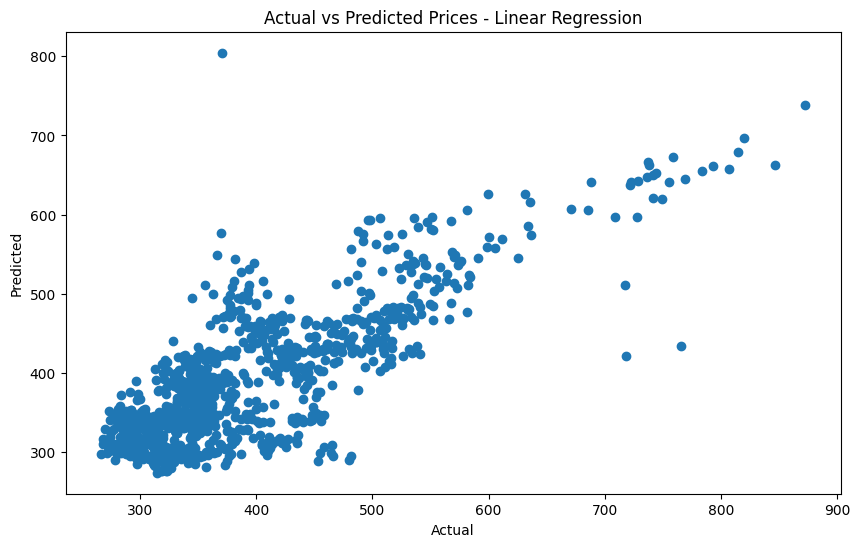

InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

In [27]:
r2_scores = []
mae_scores = []
rmse_scores=[]

# Initialisation des modèles
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='auto', random_state=42),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
}

# Initialisation des métriques de performance
best_model_name = None
best_r2_score = float('-inf')

# Entrainement et test des différents modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")
    print(f"  Root Mean Squared Error: {rmse}")
    print()
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

  # Représentation graphique des résultats
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Prices - {name}')
    plt.show()

    # Boucle conditionnelle nous permettant de sélectionner le modèle avec le meilleur r2
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model_name = name

# Affichage du modèle le plus efficace sur notre data
print(f"The most efficient model based on R-squared score is: {best_model_name} with R-squared = {best_r2_score}")


Visualisation graphique de nos R2 ainsi que de notre MAE pour comparer nos modèles de régression

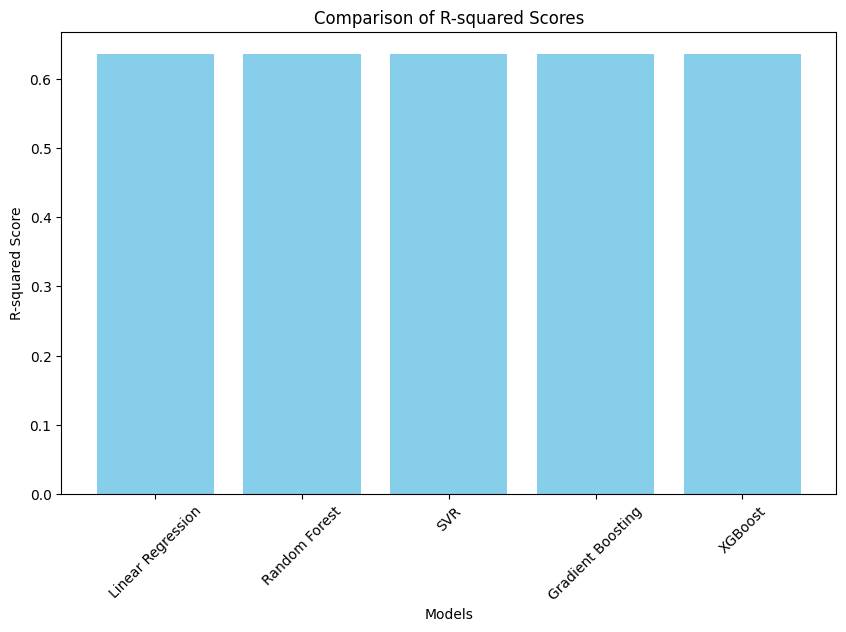

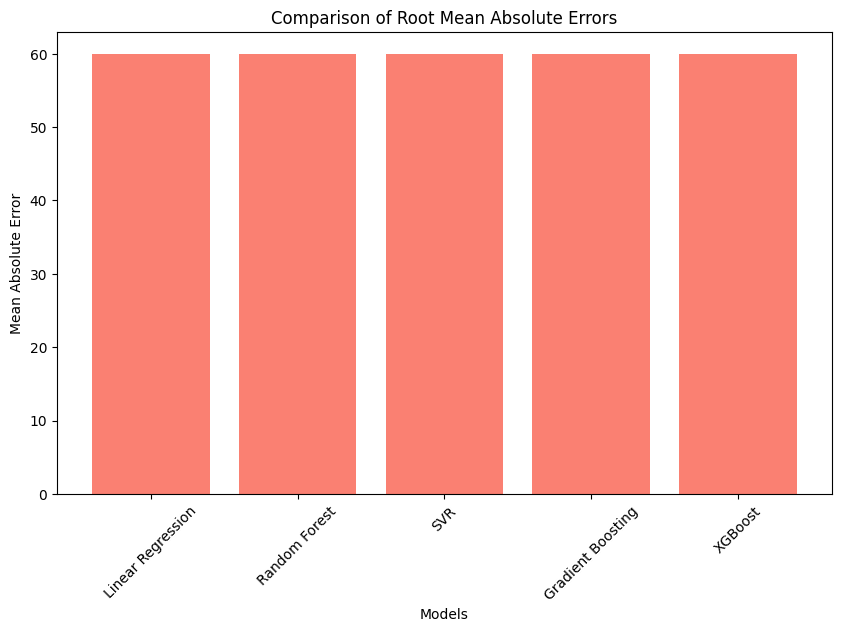

In [28]:
# R-squared scores
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), r2_scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R-squared Score')
plt.title('Comparison of R-squared Scores')
plt.xticks(rotation=45)
plt.show()

# mean absolute errors
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), rmse_scores, color='salmon')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Root Mean Absolute Errors')
plt.xticks(rotation=45)
plt.show()

Nous travaillons maintenant avec le Random Forest qui semble être notre modèle le plus performant (à partir de l'analyse graphique et des métriques de performances)

# 7 - Choix du modèle et optimisation

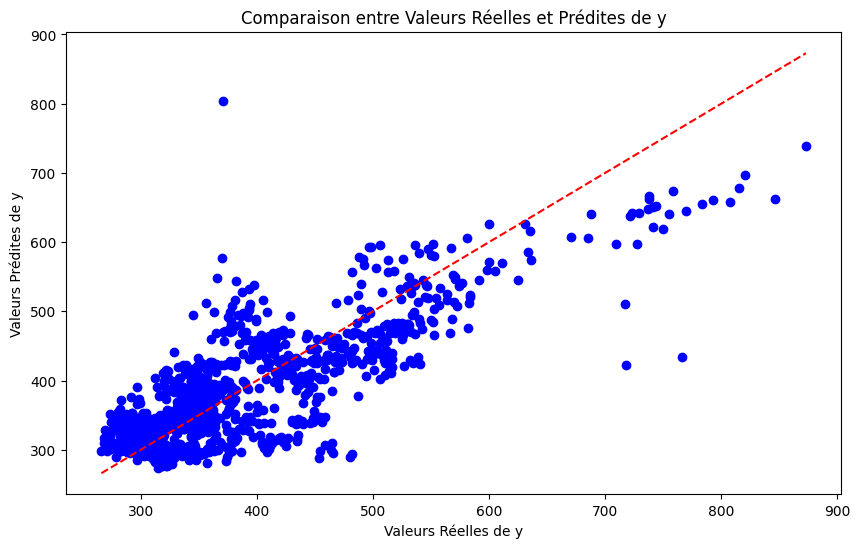

In [29]:
# Utilisation du meilleur modèle pour faire des prédictions sur les données de test
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Valeurs Réelles de y')
plt.ylabel('Valeurs Prédites de y')
plt.title('Comparaison entre Valeurs Réelles et Prédites de y')
plt.show()


On va tenter de voir si il y a présence d'overfitting sur notre modèle

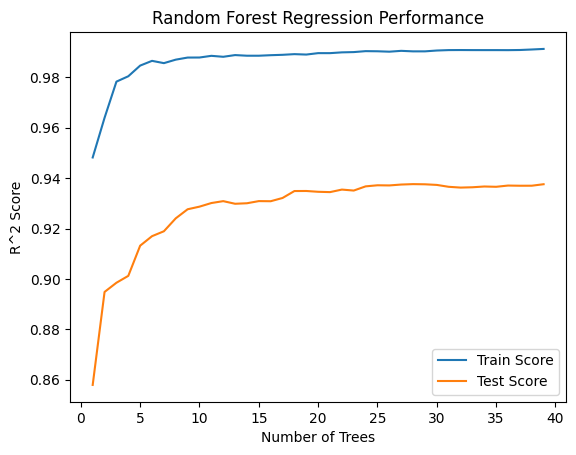

In [30]:
# Initialiser une liste pour stocker les scores d'entraînement et de test
train_scores = []
test_scores = []

# Essayer différents nombres d'arbres dans le Random Forest
num_trees_range = range(1, 40, 1)
for num_trees in num_trees_range:
    # Créer et entraîner le modèle Random Forest
    model = RandomForestRegressor(n_estimators=num_trees, random_state=42)
    model.fit(X_train, y_train)

    # Calculer les scores d'entraînement et de test
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # Ajouter les scores à la liste
    train_scores.append(train_score)
    test_scores.append(test_score)

# Tracer les scores en fonction du nombre d'arbres
plt.plot(num_trees_range, train_scores, label='Train Score')
plt.plot(num_trees_range, test_scores, label='Test Score')
plt.xlabel('Number of Trees')
plt.ylabel('R^2 Score')
plt.title('Random Forest Regression Performance')
plt.legend()
plt.show()

Moyenne des scores de validation croisée

In [31]:
# Générer des données de régression synthétiques
X, y = make_regression(n_samples=1000, n_features=20, noise=0.3, random_state=42)

# Créer un modèle Random Forest
model = RandomForestRegressor(n_estimators=5, random_state=42)

# Effectuer la validation croisée
cv_scores = cross_val_score(model, X, y, cv=10, scoring='r2')

# Afficher les scores de validation croisée
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.69518277 0.7858873  0.71215125 0.6909322  0.68485854 0.75241696
 0.71877689 0.68552867 0.72841676 0.65979666]
Mean CV Score: 0.7113947990822403


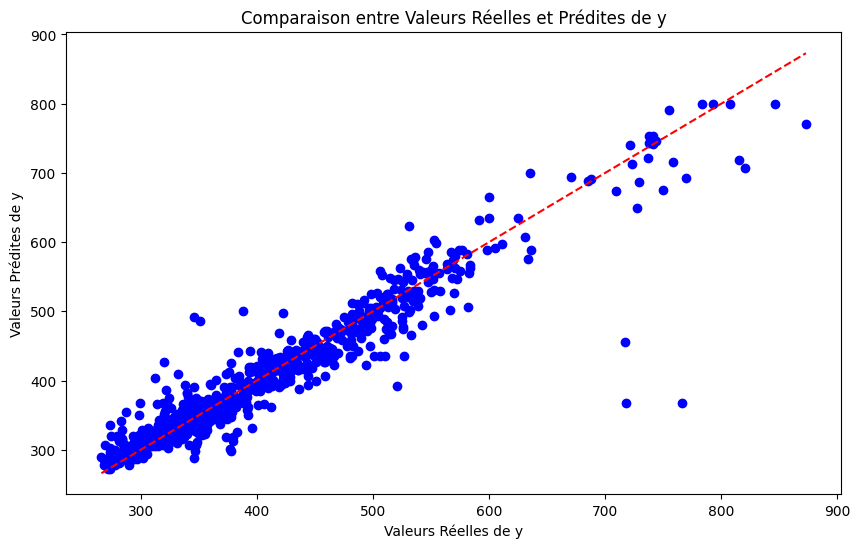

In [32]:

best_params = {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}
random_forest_adjusted = RandomForestRegressor(**best_params)
random_forest_adjusted.fit(X_train, y_train)
y_pred_best_adjusted = random_forest_adjusted.predict(X_test)



plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_adjusted, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')
plt.xlabel('Valeurs Réelles de y')
plt.ylabel('Valeurs Prédites de y')
plt.title('Comparaison entre Valeurs Réelles et Prédites de y')
plt.show()

# 8 - Analyse des résidus

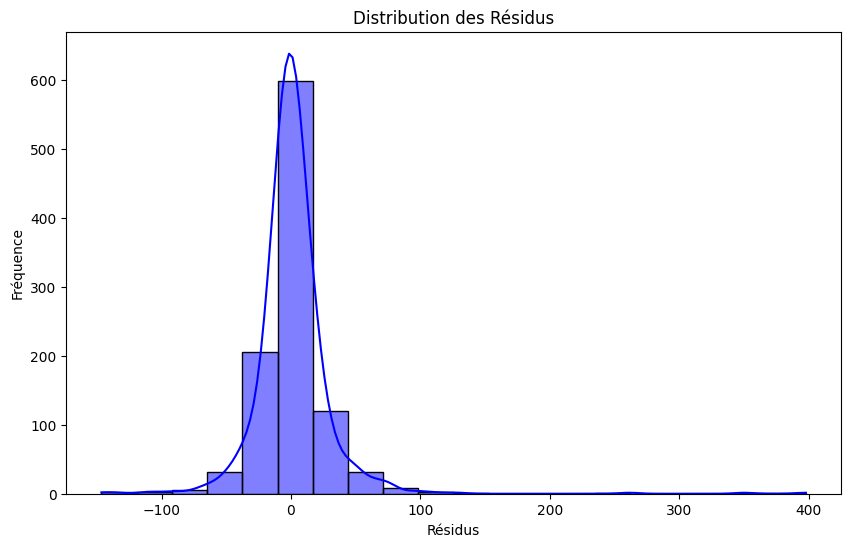

In [33]:
# Calculer les résidus comme la différence entre notre base de test et nos prédictions avec le meilleur modèle
residuals = y_test - y_pred_best_adjusted


plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=20)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Distribution des Résidus')
plt.show()

# 9 - Comparaison du cours historique et du cours prédit

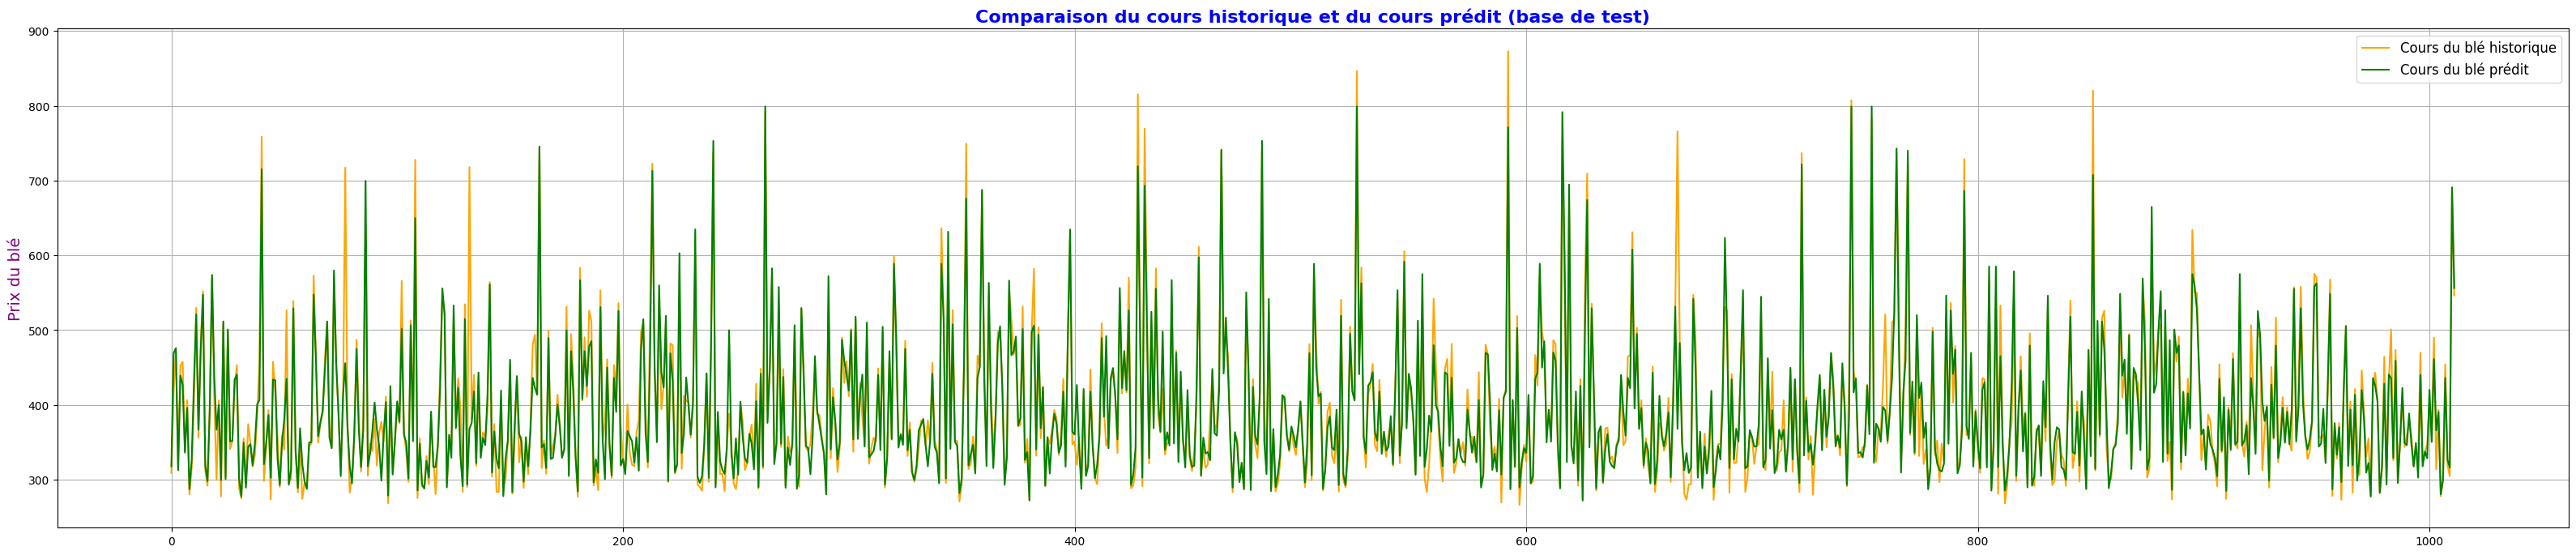

In [34]:
plt.figure(figsize=(40, 8))
plt.plot(y_test, color="orange", label='Cours du blé historique')
plt.plot(y_pred_best_adjusted, color="green", label='Cours du blé prédit')
plt.title("Comparaison du cours historique et du cours prédit (base de test)", fontsize=16, fontweight='bold', color='blue')
plt.xlabel("", fontsize=14, color='purple')
plt.ylabel("Prix du blé", fontsize=14, color='purple')
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

# Prédiction de notre cours (sur la valeur la plus récente de notre dataframe)

In [35]:
predictions_train = np.stack([tree.predict(X_train) for tree in random_forest_adjusted.estimators_], axis=0)

# Calcul de la variance des prédictions pour chaque observation dans l'ensemble de données d'entraînement
variance_train = np.var(predictions_train, axis=0)
moyenne_predictions_train = np.mean(predictions_train, axis=0)
# Calcul de la moyenne de la variance des prédictions
average_variance_train = np.mean(variance_train)

stdeviation=np.sqrt(average_variance_train)

# Sélectionnez la dernière valeur de y
last_y_value = yforpredict[-1]

# Affichez la dernière valeur de y
print("Valeur historique du cours au 12/04/2024:",last_y_value)

#Détermination d'un intervalle de confiance à partir des prédictions

last_row_X_test = X_test[-1:]
y_pred_best_adjusted = random_forest_adjusted.predict(last_row_X_test)
borneintervallemoins=y_pred_best_adjusted-1.96*(stdeviation/np.sqrt(len(df)))
borneintervalleplus=y_pred_best_adjusted+1.96*(stdeviation/np.sqrt(len(df)))

print("Intervalle de confiance à 95% de notre prédiction le 12/04/2024:[",borneintervallemoins,";",borneintervalleplus,"]")



Valeur historique du cours au 12/04/2024: 387.28
Intervalle de confiance à 95% de notre prédiction le 12/04/2024:[ [555.53567591] ; [557.11556853] ]
